<a name='index'></a>
# Index

## [Yolo Data](#yolo-data)

* [Step 1 - Import required libraries](#data-step-1)
* [Step 2 - Create data folders](#data-step-2)
* [Step 3 - Process data function](#data-step-3)
* [Step 4 - Create pre-process data function](#data-step-4)
* [Step 5 - Run and create yolo dataset](#data-step-5)

## [Yolo Run](#yolo-run)
* [Step 1 - Import required libraries](#run-step-1)
* [Step 2 - Clone Yolo V5](#run-step-2)
* [Step 3 - Mount Google drive](#run-step-3)
* [Step 4 - Wandb login](#run-step-4)
* [Step 5 - Yolov5 training](#run-step-5)
* [Step 6 - Yolov5 Inference](#run-step-6)
* [Step 7 - Visualize inference results](#run-step-7)
* [Step 8 - Create & Save csv result file](#run-step-8)

<a name='yolo-data'></a>
## **Yolo Data**
[Back to Index](#index)

<a name='data-step-1'></a>
### **Step 1**: Import required libraries
[Back to Index](#index)

In [ ]:
!pip install pydicom
import os
import shutil

import numpy as np
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from pydicom import dcmread
import cv2

     |████████████████████████████████| 1.9MB 9.2MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name='data-step-2'></a>
### **Step 2**: Create data folders
[Back to Index](#index)

In [ ]:
#os.chdir("/content/drive/MyDrive/rsna/")
DATA_PATH      = "/content/drive/MyDrive/rsna/stage_2_train_images"
OUTPUT_PATH    = "/content/drive/MyDrive/rsna/dataset_formats/yolov5_01"
INPUT_CSV_PATH = '/content/drive/MyDrive/rsna/stage_2_train_labels.csv'
nrows = 100

In [ ]:
# try:
#   shutil.rmtree(OUTPUT_PATH)
#   os.makedirs(OUTPUT_PATH)
# except:
#   os.makedirs(OUTPUT_PATH)

folders = ['images',
           'labels',
           'images/train',
           'labels/train',
           'images/validation',
           'labels/validation',
           ]

for folder in folders:
  os.makedirs(os.path.join(OUTPUT_PATH,folder))

<a name='data-step-3'></a>
### **Step 3**: Process data function
[Back to Index](#index)

In [ ]:
def process_data(data,OUTPUT_PATH, data_type="train"):
    for _, row in tqdm(data.iterrows(), total=len(data)):
        image_name = row["patientId"]
        bounding_boxes = row["bboxes"]
        yolo_data = []
        for bbox in bounding_boxes:
            x = bbox[0]
            y = bbox[1]
            w = bbox[2]
            h = bbox[3]
            x_center = x + w / 2
            y_center = y + h / 2
            x_center /= 1024.0
            y_center /= 1024.0
            w /= 1024.0
            h /= 1024.0
            yolo_data.append([
                              0,
                              x_center,
                              y_center,
                              w,
                              h
                              ])
        yolo_data = np.array(yolo_data)
        np.savetxt(
            os.path.join(OUTPUT_PATH,
                         f"labels/{data_type}/{image_name}.txt"
                         ),
            yolo_data,
            fmt=["%d", "%f", "%f", "%f", "%f"],
        )
        img_jpg = dcmread(os.path.join(DATA_PATH, f"{image_name}.dcm")).pixel_array
        
        cv2.imwrite(
            os.path.join(
                OUTPUT_PATH,
                f"images/{data_type}/{image_name}.jpg"
                ),
            img_jpg
            )

        # shutil.copyfile(
        #     os.path.join(DATA_PATH, f"{image_name}.dcm"),
        #     os.path.join(OUTPUT_PATH, f"images/{data_type}/{image_name}.dcm"),
        # )

<a name='data-step-4'></a>
### **Step 4**: Create pre-process data function
[Back to Index](#index)

In [ ]:
def create_preprocessed_data(INPUT_CSV_PATH,DATA_PATH,OUTPUT_PATH,nrows = None):
  df = pd.read_csv(INPUT_CSV_PATH,nrows = nrows)
  df['dicom_path'] = DATA_PATH + df['patientId'] + '.dcm'    
  df = df[df["Target"] == 1].copy()    
  df["bboxes"] = df.apply(
                          lambda row: [
                                      row["x"],
                                      row["y"],
                                      row["width"],
                                      row["height"]
                                      ], axis=1
                          )
  df = df.groupby("patientId")["bboxes"]\
        .apply(list)\
        .reset_index(name="bboxes")
  df_train, df_valid = model_selection.train_test_split(df,
                                                        test_size=0.1,
                                                        random_state=42,
                                                        shuffle=True
                                                        )
  df_train = df_train.reset_index(drop=True)
  df_valid = df_valid.reset_index(drop=True)

  process_data(df_train,OUTPUT_PATH,data_type="train")
  process_data(df_valid,OUTPUT_PATH, data_type="validation")

<a name='data-step-5'></a>
### **Step 5**: Run and create yolo dataset
[Back to Index](#index)

In [ ]:
#run required functions
create_preprocessed_data(INPUT_CSV_PATH,DATA_PATH,OUTPUT_PATH,nrows = nrows)

In [ ]:
!cp \
"/content/drive/MyDrive/rsna/dataset_formats/rsna.yaml" \
"/content/drive/MyDrive/rsna/dataset_formats/rsna_01.yaml"

<a name='yolo-run'></a>
## **Yolo Run**
[Back to Index](#index)

<a name='run-step-1'></a>
### **Step 1**: Import required libraries
[Back to Index](#index)

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import pandas as pd
%matplotlib inline

<a name='run-step-2'></a>
### **Step 2**: Clone Yolo V5
[Back to Index](#index)

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
%pip install -qr requirements.txt
from IPython.display import Image, clear_output
from PIL import Image
clear_output()
print('Setup complete. Using torch %s %s' %(torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.1+cu101 _CudaDeviceProperties(name='Tesla P4', major=6, minor=1, total_memory=7611MB, multi_processor_count=20)


<a name='run-step-3'></a>
### **Step 3**: Mount Google drive
[Back to Index](#index)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name='run-step-4'></a>
### **Step 4**: Wandb login
[Back to Index](#index)

In [ ]:
!pip install -q wandb
!wandb login

     |████████████████████████████████| 2.0MB 6.6MB/s 
     |████████████████████████████████| 133kB 25.5MB/s 
     |████████████████████████████████| 163kB 21.5MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<a name='run-step-5'></a>
### **Step 5**: Yolov5 training
[Back to Index](#index)

In [ ]:
!python train.py --weights '/content/drive/MyDrive/rsna/weights/Yolo_weights_10 Feb.pt'\
                 --epochs 10\
                 --batch-size 10\
                 --img-size 256\
                 --data '/content/drive/MyDrive/rsna/dataset_formats/rsna.yaml'\
                 --nosave\
                 --cache

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 v4.0-109-gfd96810 torch 1.7.1+cu101 CUDA:0 (Tesla P4, 7611.9375MB)

Namespace(adam=False, batch_size=10, bucket='', cache_images=True, cfg='', data='/content/drive/MyDrive/rsna/dataset_formats/rsna.yaml', device='', entity=None, epochs=10, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[244, 244], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=True, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=10, weights='/content/drive/MyDrive/rsna/weights/Yolo_weights_10 Feb.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-03-01 10:47:50.861198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfull

In [ ]:
!cp \
"/content/yolov5/runs/train/exp/weights/best.pt" \
"/content/drive/MyDrive/rsna/weights/yolo/yolo_1_mar_256_10_epochs.pt"

<a name='run-step-6'></a>
### **Step 6**: Yolov5 Inference
[Back to Index](#index)

In [ ]:
!python detect.py --weights '/content/drive/MyDrive/rsna/weights/yolo/yolo_1_mar_256_10_epochs.pt'\
                  --img-size 256\
                  --conf-thres 0.5\
                  --source "/content/drive/MyDrive/rsna/jpg_stage_2_test_images"\
                  --save-txt \
                  --save-conf

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=256, iou_thres=0.45, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/content/drive/MyDrive/rsna/jpg_stage_2_test_images', update=False, view_img=False, weights=['/content/drive/MyDrive/rsna/weights/yolo/yolo_1_mar_256_10_epochs.pt'])
YOLOv5 v4.0-109-gfd96810 torch 1.7.1+cu101 CUDA:0 (Tesla P4, 7611.9375MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
image 1/3000 /content/drive/MyDrive/rsna/jpg_stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg: 256x256 Done. (0.011s)
image 2/3000 /content/drive/MyDrive/rsna/jpg_stage_2_test_images/0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg: 256x256 Done. (0.011s)
image 3/3000 /content/drive/MyDrive/rsna/jpg_stage_2_test_images/000686d7-f4fc-448d-97a0-44fa9c5d3aa6.jpg: 256x256 Done. (0.011s)
image 4/3000 /content/drive/MyDrive/rsna/jpg_stage_2_test_images/000e3a7d

<a name='run-step-7'></a>
### **Step 7**: Visualize inference results
[Back to Index](#index)

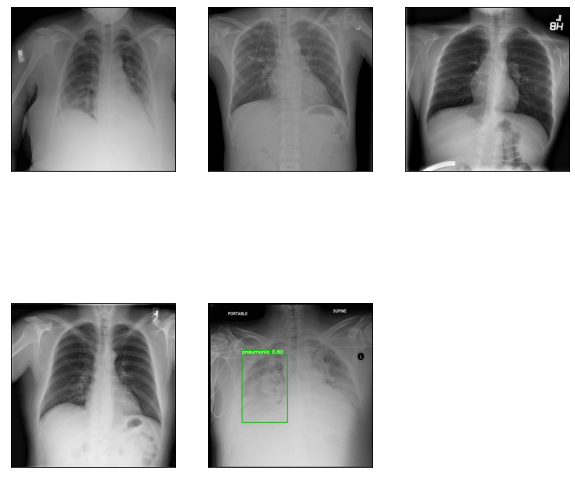

In [ ]:
plt.figure(figsize=(10,10))
res_path = []
for root,dir,files in os.walk('/content/yolov5/runs/detect/exp4'):
  for file in files:
    path = os.path.join(root,file)
    res_path.append(path)  

#for i in range(len(res_path)):
for i in range(0,5):
  if res_path[i].split(".")[-1] == "jpg":
    ax = plt.subplot(2,
                     3,
                     i+1,
                     xticks = [],
                     yticks = []
                     )
    im = Image.open(res_path[i])  
    ax.imshow(im)  
plt.show()

<a name='run-step-8'></a>
### **Step 8**: Create & Save csv result file
[Back to Index](#index)

In [ ]:
def create_result_csv(test_df,source_labels_directory):
  for idx, row in tqdm(test_df.iterrows()):
    file_path = os.path.join(
        source_labels_directory,
        row["patientId"]+".txt"
        )
    if os.path.exists(file_path):
      with open(file_path, 'r') as reader:
        box_str = ""
        for line in reader:
          box = "{} {} {} {} {}".format(
              "0.5",
              round(
                  (float(line.split()[1]) - float(line.split()[3])/2)*1024,
                  2
                  ),
              round(
                  (float(line.split()[2]) - float(line.split()[4])/2)*1024,
                  2
                  ),
              round(float(line.split()[3])*1024,2),
              round(float(line.split()[4])*1024,2),
          )
          box_str = " ".join([box_str, box])
      test_df.loc[idx,"PredictionString"] = box_str.strip()
    else:
      test_df.loc[idx,"PredictionString"] = ""
  return test_df

In [ ]:
#os.chdir("/content/yolov5/runs/detect/exp3/labels")
test_df = pd.read_csv("/content/drive/MyDrive/rsna/stage_2_sample_submission.csv")
source_labels_directory = "/content/yolov5/runs/detect/exp4/labels"
test_df = create_result_csv(test_df,source_labels_directory)
#test_df.head()

In [ ]:
test_df.to_csv(
    "/content/drive/MyDrive/rsna/rsna_results/yolov5_Feb27/test_df_yolo_05_28 Feb.csv",
    index=False
    )